## Task 2 - CLIP Fine-Tuning on the Visual Encoder

In [1]:
#@title GPU / Python / Torch sanity
import os, sys, subprocess, json, platform, torch
print("Python :", sys.version)
print("CUDA   :", torch.version.cuda)
print("Torch  :", torch.__version__)
print("Device :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
!nvidia-smi || true

Python : 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:29:10) [GCC 14.3.0]
CUDA   : 12.1
Torch  : 2.3.1+cu121
Device : NVIDIA GeForce RTX 4090
Tue Nov 11 12:23:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0 Off |                  Off |
|  0%   48C    P8             25W /  450W |   12345MiB /  24564MiB |      0%

In [2]:
# some imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from transformers import CLIPProcessor, CLIPModel, AutoProcessor, CLIPVisionModel, logging
import clip
from peft import LoraConfig, get_peft_model, TaskType
from torchinfo import summary
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import json
import warnings
import torch.nn.functional as F
from PIL import Image
import os
from datasets import load_dataset
import io
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader

import pandas as pd


def save_training_artifacts(prefix: str, title: str, train_losses, train_accuracies, val_losses=None, val_accuracies=None):
    if not train_losses:
        return
    epochs = list(range(1, len(train_losses) + 1))
    data = {
        "epoch": epochs,
        "train_loss": train_losses,
        "train_accuracy": train_accuracies,
    }
    if val_losses is not None and len(val_losses) == len(epochs):
        data["val_loss"] = val_losses
    if val_accuracies is not None and len(val_accuracies) == len(epochs):
        data["val_accuracy"] = val_accuracies
    os.makedirs("data", exist_ok=True)
    csv_path = os.path.join("data", f"{prefix}.csv")
    pd.DataFrame(data).to_csv(csv_path, index=False)
    fig = None
    try:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].plot(epochs, train_losses, label="train")
        if val_losses is not None and len(val_losses) == len(epochs):
            axes[0].plot(epochs, val_losses, label="val")
        axes[0].set_title("Loss")
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Loss")
        axes[0].legend()

        axes[1].plot(epochs, train_accuracies, label="train")
        if val_accuracies is not None and len(val_accuracies) == len(epochs):
            axes[1].plot(epochs, val_accuracies, label="val")
        axes[1].set_title("Accuracy")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Accuracy")
        axes[1].legend()

        fig.suptitle(title)
        fig.tight_layout()
        fig.savefig(os.path.join("data", f"{prefix}.png"))
        plt.show()
    except Exception:
        pass
    finally:
        if fig is not None:
            plt.close(fig)


/home/abat/conda_envs/clip/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# 降噪：避免 tokenizers 在多工情境下噴警告
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# some settings
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_ID = "openai/clip-vit-large-patch14" # pre-trained CLIP model (ViT-L/14)
BATCH_SIZE = 256 # adjust based on your GPU memory
NUM_WORKERS = 8
gradient_accumulation_steps = 1 # adjust based on your GPU memory
# For Linear Probe & LoRA
NUM_EPOCHS = 1
print(f"Using device: {DEVICE}")


processor = CLIPProcessor.from_pretrained(MODEL_ID)
model     = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
model.eval()




Using device: cuda


/home/abat/conda_envs/clip/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [4]:
# ==== Flowers102 (torchvision) ====


# 把 PIL 影像轉成 (3,224,224) 的 CLIP 規格 tensor
def clip_image_transform(image):
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)
    image = image.convert("RGB")
    px = processor(images=image, return_tensors="pt")["pixel_values"][0]  # (3,224,224)
    return px

flowers102_test_dts = Flowers102(
    root="./data",
    split="test",
    transform=clip_image_transform,
    download=True
)
flowers102_train_dts = Flowers102(
    root="./data",
    split="train",
    transform=clip_image_transform,
    download=True
)

# validation split for Flowers102 (torchvision provides 'val' split)
flowers102_val_dts = Flowers102(
    root="./data",
    split="val",
    transform=clip_image_transform,
    download=True
)
print(f"Total test samples (Flowers102): {len(flowers102_test_dts)}")  # 6149

flowers102_train_loader = DataLoader(
    flowers102_train_dts,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

flowers102_val_loader = DataLoader(
    flowers102_val_dts,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

flowers102_test_loader = DataLoader(
    flowers102_test_dts,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# 類別名稱（使用你上傳的 cat_to_name.json）
with open("./data/cat_to_name.json", "r") as f:
    cat_to_name = json.load(f)
flowers102_class_names = [cat_to_name[str(i)] for i in range(1, 103)]


Total test samples (Flowers102): 6149


In [5]:
# ==== CUB-200-2011 (HF datasets) ====

birds_200 = load_dataset("bentrevett/caltech-ucsd-birds-200-2011", cache_dir="./data")
cub_bird_test_raw = birds_200["test"]
cub_bird_train_raw = birds_200["train"]
# build a small validation split from training set (10%)
cub_bird_train_raw = cub_bird_train_raw
cub_bird_train_raw, cub_bird_val_raw = cub_bird_train_raw.train_test_split(test_size=0.1, seed=42).values()
print(f"Total train/val/test samples (CUB): {len(cub_bird_train_raw)}/{len(cub_bird_val_raw)}/{len(cub_bird_test_raw)}")

def _to_pil_image_safe(img):
    """Robust convert HF dataset image (PIL/ndarray/list/bytes) -> PIL.Image."""
    if isinstance(img, Image.Image):
        return img
    if isinstance(img, np.ndarray):
        return Image.fromarray(img)
    # list may be list-of-ints (bytes) or nested lists (HWC)
    if isinstance(img, (list, tuple)):
        # list of ints -> bytes
        if all(isinstance(x, (int, np.integer)) for x in img):
            return Image.open(io.BytesIO(bytes(img)))
        # else try to convert to array (may raise ValueError for ragged)
        try:
            arr = np.asarray(img, dtype=np.uint8)
            return Image.fromarray(arr)
        except Exception as ex:
            raise TypeError(f"Cannot convert list image to PIL (ragged?): {ex}") from ex
    if isinstance(img, (bytes, bytearray)):
        return Image.open(io.BytesIO(img))
    raise TypeError(f"Unsupported image type for conversion to PIL: {type(img)}")

def cub_transform(example):
    """
    Accept both single example and batch-dict (where example['image'] is a list).
    Return pixel_values as numpy arrays (C,H,W) to keep HF formatting/collate stable.
    """
    def proc_one(img):
        pil = _to_pil_image_safe(img).convert("RGB")
        px = processor(images=pil, return_tensors="pt")["pixel_values"][0]  # tensor (3,224,224)
        return px.numpy()

    # batched call from datasets.formatting may pass lists
    if isinstance(example, dict) and isinstance(example.get("image"), (list, tuple)):
        imgs = [proc_one(im) for im in example["image"]]
        labs = list(example["label"])
        return {"pixel_values": imgs, "label": labs}
    # single example
    img = example["image"]
    px_arr = proc_one(img)
    return {"pixel_values": px_arr, "label": example["label"]}

cub_bird_train_dts = cub_bird_train_raw.with_transform(cub_transform)
cub_bird_val_dts = cub_bird_val_raw.with_transform(cub_transform)
cub_bird_test_dts = cub_bird_test_raw.with_transform(cub_transform)

# 強韌的 collate：把所有樣本疊成 (B,3,224,224)，label 成 (B,)
def _to_chw224(x: torch.Tensor) -> torch.Tensor:
    x = torch.as_tensor(x)
    if not torch.is_floating_point(x):
        x = x.float() / 255.0
    if x.ndim == 3:
        # HWC -> CHW
        if x.shape[-1] == 3 and x.shape[0] != 3:
            x = x.permute(2, 0, 1)
        # 灰階擴通道
        if x.shape[0] == 1:
            x = x.repeat(3, 1, 1)
        elif x.shape[0] != 3:
            raise ValueError(f"Unexpected channel dim: {x.shape}")
    elif x.ndim == 2:
        x = x.unsqueeze(0).repeat(3, 1, 1)
    else:
        raise ValueError(f"Unexpected ndim {x.ndim} for image with shape {tuple(x.shape)}")
    if x.shape[1:] != (224, 224):
        x = F.interpolate(x.unsqueeze(0).float(), size=(224, 224),
                          mode="bilinear", align_corners=False).squeeze(0)
    return x.float()

def hf_collate_fn(batch):
    imgs = torch.stack([_to_chw224(b["pixel_values"]) for b in batch], dim=0)  # (B,3,224,224)
    labs = torch.tensor([int(b["label"]) for b in batch], dtype=torch.long)    # (B,)
    return {"pixel_values": imgs, "label": labs}

from torch.utils.data import DataLoader
cub_bird_train_loader = DataLoader(
    cub_bird_train_dts,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=hf_collate_fn
)

cub_bird_val_loader = DataLoader(
    cub_bird_val_dts,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=hf_collate_fn
)

cub_bird_test_loader = DataLoader(
    cub_bird_test_dts,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=hf_collate_fn
)

# 類別名稱由 HF features 提供
cub_bird_class_names = cub_bird_test_raw.features["label"].names

import re
def clean_cub_name(name: str) -> str:
    name = re.sub(r'^\d+\.', '', name)   # remove leading numeric prefix
    name = name.replace('_', ' ')
    return name.strip()

cub_bird_class_names = [clean_cub_name(n) for n in cub_bird_class_names]
for x in cub_bird_class_names[:10]:
    print(x)

Total train/val/test samples (CUB): 5394/600/5794
Black footed Albatross
Laysan Albatross
Sooty Albatross
Groove billed Ani
Crested Auklet
Least Auklet
Parakeet Auklet
Rhinoceros Auklet
Brewer Blackbird
Red winged Blackbird


Start Linear Probing

--- Starting Method: Linear Probing Flowers ---


Epoch 1/1 [Train]: 100%|██████████| 16/16 [00:05<00:00,  2.94it/s]


Epoch 1 - Train Loss: 4.6067 | Train Acc: 4.90% | Val Loss: 4.5639 | Val Acc: 23.14% | Time: 10.74s


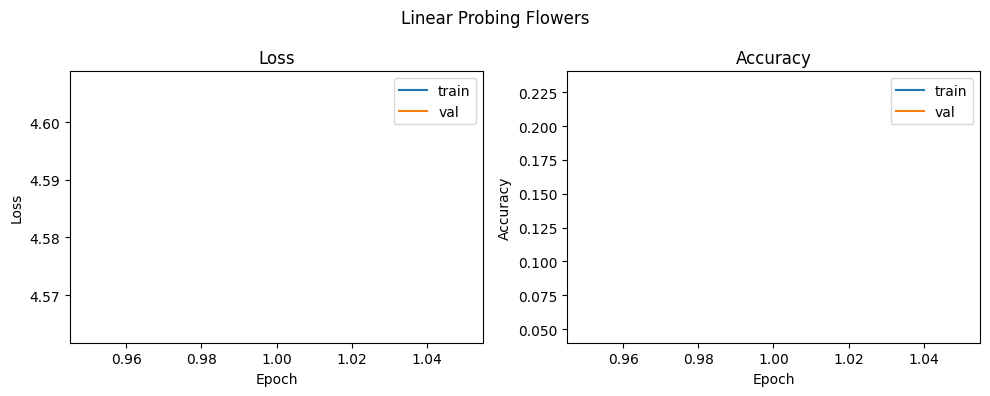

Test Loss: 4.5721 | Test Acc: 17.71%
Linear probing Flowers finished


In [6]:

print("--- Starting Method: Linear Probing Flowers ---")

# We'll use the existing CLIP model (loaded earlier) and attach a linear classifier on top of image features.
# Get image feature dimension with a dummy forward
with torch.no_grad():
    dummy_px = processor(images=Image.new("RGB", (224, 224), "white"), return_tensors="pt")["pixel_values"].to(DEVICE)
    feat = model.get_image_features(pixel_values=dummy_px)
    feat_dim = feat.shape[-1]

# Freeze full vision encoder to perform linear probing
vision_model = model.vision_model
visual_projection = getattr(model, 'visual_projection', None)
for p in vision_model.parameters():
    p.requires_grad = False
if visual_projection is not None:
    for p in visual_projection.parameters():
        p.requires_grad = False

# Simple linear head
def make_head(num_classes):
    return nn.Linear(feat_dim, num_classes).to(DEVICE)

num_classes = len(flowers102_class_names)
train_loader = flowers102_train_loader if 'flowers102_train_loader' in globals() else None
val_loader = flowers102_val_loader if 'flowers102_val_loader' in globals() else None
test_loader = flowers102_test_loader if 'flowers102_test_loader' in globals() else None
class_names = flowers102_class_names

head = make_head(num_classes)

# training setup
criterion = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = torch.optim.Adam(head.parameters(), lr=lr)
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

from time import time

def evaluate(loader):
    head.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, dict):
                imgs, labels = batch['pixel_values'], batch['label']
            else:
                imgs, labels = batch
            if isinstance(imgs, list):
                imgs = torch.stack(imgs, dim=0)
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)
            feats = model.get_image_features(pixel_values=imgs)
            feats = feats / feats.norm(dim=-1, keepdim=True)
            logits = head(feats)
            loss = criterion(logits, labels)
            preds = logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loss_sum += loss.item() * labels.size(0)
    return loss_sum / total, correct / total

# If no training loader is available, skip training and just run evaluation on test set
if train_loader is None:
    print('No training loader prepared for the chosen dataset; running evaluation on test set only')
    test_loss, test_acc = evaluate(test_loader)
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")
else:
    # training loop
    for epoch in range(NUM_EPOCHS):
        head.train()
        epoch_start = time()
        running_loss = 0.0
        running_correct = 0
        seen = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
            if isinstance(batch, dict):
                imgs, labels = batch['pixel_values'], batch['label']
            else:
                imgs, labels = batch
            if isinstance(imgs, list):
                imgs = torch.stack(imgs, dim=0)
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            feats = model.get_image_features(pixel_values=imgs)
            feats = feats / feats.norm(dim=-1, keepdim=True)
            logits = head(feats)
            preds = logits.argmax(dim=-1)
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            running_correct += (preds == labels).sum().item()
            seen += labels.size(0)

        train_loss = running_loss / max(1, seen)
        train_acc = running_correct / max(1, seen)
        if val_loader is not None:
            val_loss, val_acc = evaluate(val_loader)
        else:
            val_loss, val_acc = evaluate(test_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        epoch_end = time()
        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | Time: {epoch_end-epoch_start:.2f}s")

    save_training_artifacts("linear_flowers", "Linear Probing Flowers", train_losses, train_accuracies, val_losses, val_accuracies)

    # final test
    test_loss, test_acc = evaluate(test_loader)
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

print('Linear probing Flowers finished')


--- Starting Method: Linear Probing Birds ---


Epoch 1/1 [Train]: 100%|██████████| 85/85 [00:27<00:00,  3.14it/s]


Epoch 1 - Train Loss: 5.1892 | Train Acc: 15.70% | Val Loss: 5.0695 | Val Acc: 42.50% | Time: 30.37s


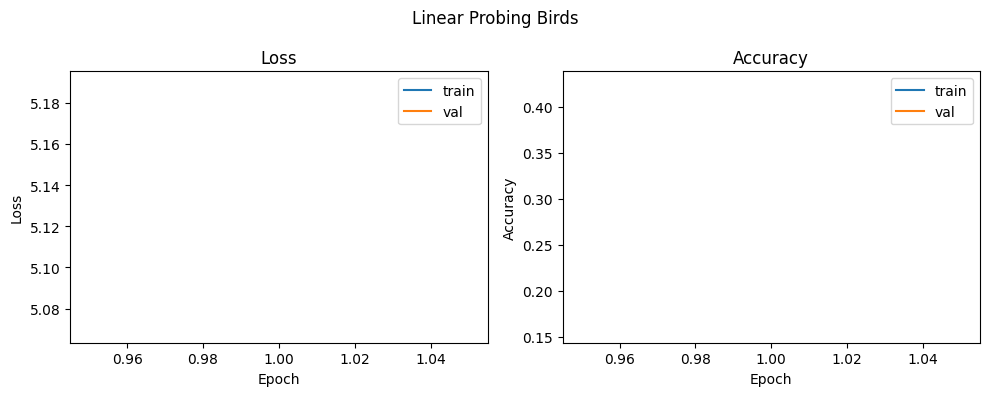

Test Loss: 5.0540 | Test Acc: 49.52%
Linear probing Birds finished


In [7]:

print("--- Starting Method: Linear Probing Birds ---")

# We'll use the existing CLIP model (loaded earlier) and attach a linear classifier on top of image features.
# Get image feature dimension with a dummy forward
with torch.no_grad():
    dummy_px = processor(images=Image.new("RGB", (224, 224), "white"), return_tensors="pt")["pixel_values"].to(DEVICE)
    feat = model.get_image_features(pixel_values=dummy_px)
    feat_dim = feat.shape[-1]

# Freeze full vision encoder to perform linear probing
vision_model = model.vision_model
visual_projection = getattr(model, 'visual_projection', None)
for p in vision_model.parameters():
    p.requires_grad = False
if visual_projection is not None:
    for p in visual_projection.parameters():
        p.requires_grad = False

# Simple linear head
def make_head(num_classes):
    return nn.Linear(feat_dim, num_classes).to(DEVICE)

num_classes = len(cub_bird_class_names)
# If train/val splits aren't prepared, fall back to test-only evaluation
train_loader = cub_bird_train_loader if 'cub_bird_train_loader' in globals() else None
val_loader = cub_bird_val_loader if 'cub_bird_val_loader' in globals() else None
test_loader = cub_bird_test_loader if 'cub_bird_test_loader' in globals() else None
class_names = cub_bird_class_names

head = make_head(num_classes)

# training setup
criterion = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = torch.optim.Adam(head.parameters(), lr=lr)
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

from time import time

def evaluate(loader):
    head.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, dict):
                imgs, labels = batch['pixel_values'], batch['label']
            else:
                imgs, labels = batch
            if isinstance(imgs, list):
                imgs = torch.stack(imgs, dim=0)
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)
            feats = model.get_image_features(pixel_values=imgs)
            feats = feats / feats.norm(dim=-1, keepdim=True)
            logits = head(feats)
            loss = criterion(logits, labels)
            preds = logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loss_sum += loss.item() * labels.size(0)
    return loss_sum / total, correct / total

# If no training loader is available, skip training and just run evaluation on test set
if train_loader is None:
    print('No training loader prepared for the chosen dataset; running evaluation on test set only')
    test_loss, test_acc = evaluate(test_loader)
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")
else:
    # training loop
    for epoch in range(NUM_EPOCHS):
        head.train()
        epoch_start = time()
        running_loss = 0.0
        running_correct = 0
        seen = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
            if isinstance(batch, dict):
                imgs, labels = batch['pixel_values'], batch['label']
            else:
                imgs, labels = batch
            if isinstance(imgs, list):
                imgs = torch.stack(imgs, dim=0)
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            feats = model.get_image_features(pixel_values=imgs)
            feats = feats / feats.norm(dim=-1, keepdim=True)
            logits = head(feats)
            preds = logits.argmax(dim=-1)
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            running_correct += (preds == labels).sum().item()
            seen += labels.size(0)

        train_loss = running_loss / max(1, seen)
        train_acc = running_correct / max(1, seen)
        if val_loader is not None:
            val_loss, val_acc = evaluate(val_loader)
        else:
            val_loss, val_acc = evaluate(test_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        epoch_end = time()
        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | Time: {epoch_end-epoch_start:.2f}s")

    save_training_artifacts("linear_birds", "Linear Probing Birds", train_losses, train_accuracies, val_losses, val_accuracies)

    # final test
    test_loss, test_acc = evaluate(test_loader)
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

print('Linear probing Birds finished')


--- Starting Method: LoRA Fine-Tuning Flowers ---
LoRA path failed or PEFT not available; falling back to tuning visual projection + head. Error: IMAGE_CLASSIFICATION


Fallback Epoch 1/1 [Train]: 100%|██████████| 16/16 [00:05<00:00,  2.96it/s]


Fallback epoch 1 - Train Loss: 4.5191 | Train Acc: 32.55%


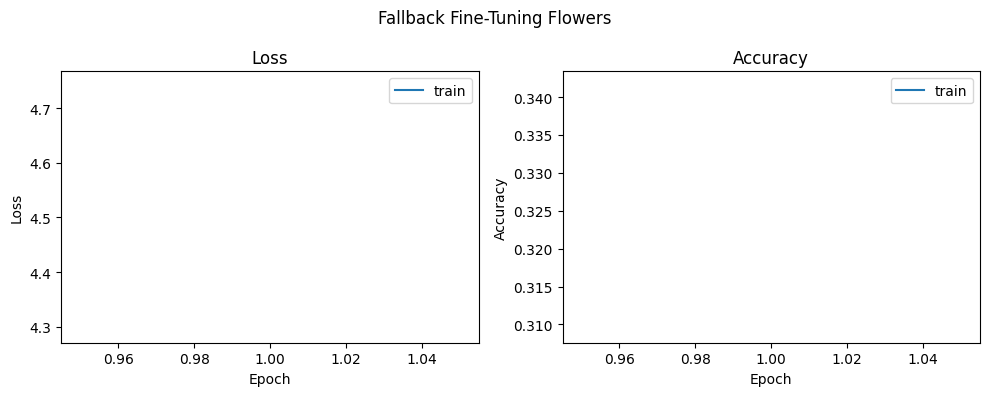

Fallback Val Acc: 82.55%
LoRA Flowers finished


In [ ]:

print("--- Starting Method: LoRA Fine-Tuning Flowers ---")

train_loader = flowers102_train_loader if 'flowers102_train_loader' in globals() else None
val_loader = flowers102_val_loader if 'flowers102_val_loader' in globals() else None
test_loader = flowers102_test_loader if 'flowers102_test_loader' in globals() else None
num_classes = len(flowers102_class_names)

# Try to apply LoRA to the vision encoder. If PEFT is unavailable or fails, fall back to tuning the visual projection + head.
try:
    # load a fresh CLIP model to avoid interference
    model_lora = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
    vision_model = model_lora.vision_model

    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=["q_proj", "v_proj", "k_proj"],
        lora_dropout=0.05,
        bias="none",
    )

    vision_model_lora = get_peft_model(vision_model, lora_config)
    model_lora.vision_model = vision_model_lora
    print("LoRA Model - Trainable Parameters:")
    vision_model_lora.print_trainable_parameters()

    # freeze visual projection and text encoder if present
    if hasattr(model_lora, 'visual_projection') and model_lora.visual_projection is not None:
        for p in model_lora.visual_projection.parameters():
            p.requires_grad = False

    # prepare head
    with torch.no_grad():
        dummy_px = processor(images=Image.new("RGB", (224, 224), "white"), return_tensors="pt")["pixel_values"].to(DEVICE)
        feat = model_lora.get_image_features(pixel_values=dummy_px)
        feat_dim = feat.shape[-1]
    head = nn.Linear(feat_dim, num_classes).to(DEVICE)

    params = list(filter(lambda p: p.requires_grad, model_lora.parameters())) + list(head.parameters())
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params, lr=5e-4)

    def eval_model(m):
        m.eval(); head.eval()
        total, correct, loss_sum = 0, 0, 0.0
        loader = val_loader if val_loader is not None else test_loader
        with torch.no_grad():
            for batch in loader:
                if isinstance(batch, dict):
                    imgs, labels = batch['pixel_values'], batch['label']
                else:
                    imgs, labels = batch
                if isinstance(imgs, list):
                    imgs = torch.stack(imgs, dim=0)
                imgs = imgs.to(DEVICE)
                labels = labels.to(DEVICE)
                feats = m.get_image_features(pixel_values=imgs)
                feats = feats / feats.norm(dim=-1, keepdim=True)
                logits = head(feats)
                loss = criterion(logits, labels)
                preds = logits.argmax(dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                loss_sum += loss.item() * labels.size(0)
        return loss_sum/total, correct/total

    # train LoRA + head (if train_loader exists)
    if train_loader is None:
        print('No training loader available for LoRA path; running quick eval instead')
        tloss, tacc = eval_model(model_lora)
        print(f"Val/Test Loss: {tloss:.4f} | Acc: {tacc*100:.2f}%")
    else:
        train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
        for epoch in range(NUM_EPOCHS):
            model_lora.train(); head.train()
            running_loss = 0.0
            running_correct = 0
            seen = 0
            for batch in tqdm(train_loader, desc=f"LoRA Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
                if isinstance(batch, dict):
                    imgs, labels = batch['pixel_values'], batch['label']
                else:
                    imgs, labels = batch
                if isinstance(imgs, list):
                    imgs = torch.stack(imgs, dim=0)
                imgs = imgs.to(DEVICE)
                labels = labels.to(DEVICE)
                feats = model_lora.get_image_features(pixel_values=imgs)
                feats = feats / feats.norm(dim=-1, keepdim=True)
                logits = head(feats)
                preds = logits.argmax(dim=-1)
                loss = criterion(logits, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * labels.size(0)
                running_correct += (preds == labels).sum().item()
                seen += labels.size(0)
            train_loss = running_loss / max(1, seen)
            train_acc = running_correct / max(1, seen)
            val_loss, val_acc = eval_model(model_lora)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            print(f"LoRA Epoch {epoch+1} - Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
        save_training_artifacts("finetuning_flowers", "LoRA Fine-Tuning Flowers", train_losses, train_accuracies, val_losses, val_accuracies)
        test_loss, test_acc = eval_model(model_lora)
        print(f"LoRA Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

except Exception as e:
    print("LoRA path failed or PEFT not available; falling back to tuning visual projection + head. Error:", e)
    # fallback approach
    model_fb = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
    if hasattr(model_fb, 'visual_projection') and model_fb.visual_projection is not None:
        for p in model_fb.visual_projection.parameters():
            p.requires_grad = True
    for p in model_fb.vision_model.parameters():
        p.requires_grad = False
    with torch.no_grad():
        dummy_px = processor(images=Image.new("RGB", (224, 224), "white"), return_tensors="pt")["pixel_values"].to(DEVICE)
        feat = model_fb.get_image_features(pixel_values=dummy_px)
        feat_dim = feat.shape[-1]
    head = nn.Linear(feat_dim, num_classes).to(DEVICE)
    optimizer = torch.optim.Adam(list(head.parameters()) + list(filter(lambda p: p.requires_grad, model_fb.parameters())), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    if train_loader is None:
        print('No training loader available for fallback; exiting fallback')
    else:
        fallback_train_losses, fallback_train_accuracies = [], []
        for epoch in range(NUM_EPOCHS):
            model_fb.train(); head.train()
            running_loss = 0.0
            running_correct = 0
            seen = 0
            for batch in tqdm(train_loader, desc=f"Fallback Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
                if isinstance(batch, dict):
                    imgs, labels = batch['pixel_values'], batch['label']
                else:
                    imgs, labels = batch
                if isinstance(imgs, list):
                    imgs = torch.stack(imgs, dim=0)
                imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
                feats = model_fb.get_image_features(pixel_values=imgs)
                feats = feats / feats.norm(dim=-1, keepdim=True)
                logits = head(feats)
                preds = logits.argmax(dim=-1)
                loss = criterion(logits, labels)
                optimizer.zero_grad(); loss.backward(); optimizer.step()
                running_loss += loss.item()*labels.size(0)
                running_correct += (preds == labels).sum().item()
                seen += labels.size(0)
            train_loss = running_loss / max(1, seen)
            train_acc = running_correct / max(1, seen)
            fallback_train_losses.append(train_loss)
            fallback_train_accuracies.append(train_acc)
            print(f"Fallback epoch {epoch+1} - Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
        save_training_artifacts("finetuning_flowers", "Fallback Fine-Tuning Flowers", fallback_train_losses, fallback_train_accuracies)
        # Evaluate fallback
        def eval_fb():
            head.eval(); model_fb.eval()
            total, correct = 0, 0
            loader = val_loader if val_loader is not None else test_loader
            with torch.no_grad():
                for batch in loader:
                    if isinstance(batch, dict):
                        imgs, labels = batch['pixel_values'], batch['label']
                    else:
                        imgs, labels = batch
                    if isinstance(imgs, list):
                        imgs = torch.stack(imgs, dim=0)
                    imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
                    feats = model_fb.get_image_features(pixel_values=imgs)
                    feats = feats / feats.norm(dim=-1, keepdim=True)
                    preds = head(feats).argmax(dim=-1)
                    correct += (preds == labels).sum().item(); total += labels.size(0)
            return correct/total
        print(f"Fallback Val Acc: {eval_fb()*100:.2f}%")

print('LoRA Flowers finished')


--- Starting Method: LoRA Fine-Tuning Birds ---
LoRA path failed or PEFT not available; falling back to tuning visual projection + head. Error: IMAGE_CLASSIFICATION


Fallback Epoch 1/1 [Train]: 100%|██████████| 85/85 [00:27<00:00,  3.14it/s]


Fallback epoch 1 - Train Loss: 4.9339 | Train Acc: 36.30%


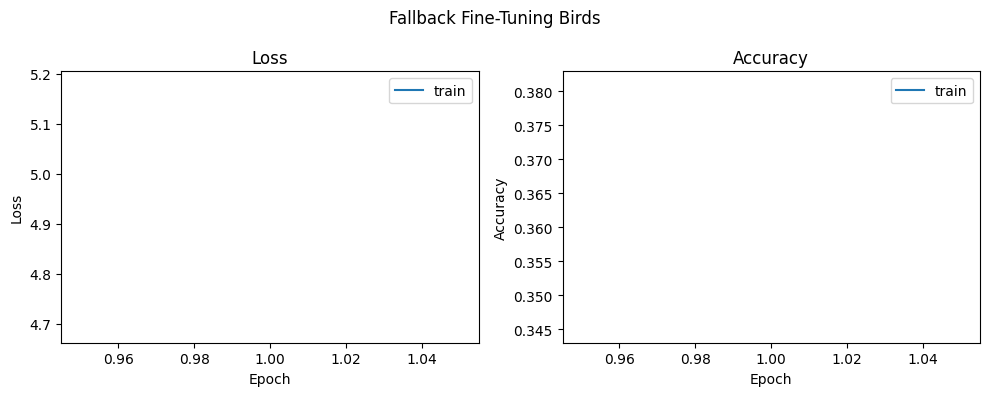

Fallback Val Acc: 56.00%
LoRA Birds finished


In [ ]:

print("--- Starting Method: LoRA Fine-Tuning Birds ---")

train_loader = cub_bird_train_loader if 'cub_bird_train_loader' in globals() else None
val_loader = cub_bird_val_loader if 'cub_bird_val_loader' in globals() else None
test_loader = cub_bird_test_loader if 'cub_bird_test_loader' in globals() else None
num_classes = len(cub_bird_class_names)

# Try to apply LoRA to the vision encoder. If PEFT is unavailable or fails, fall back to tuning the visual projection + head.
try:
    # load a fresh CLIP model to avoid interference
    model_lora = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
    vision_model = model_lora.vision_model

    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=["q_proj", "v_proj", "k_proj"],
        lora_dropout=0.05,
        bias="none",
    )

    vision_model_lora = get_peft_model(vision_model, lora_config)
    model_lora.vision_model = vision_model_lora
    print("LoRA Model - Trainable Parameters:")
    vision_model_lora.print_trainable_parameters()

    # freeze visual projection and text encoder if present
    if hasattr(model_lora, 'visual_projection') and model_lora.visual_projection is not None:
        for p in model_lora.visual_projection.parameters():
            p.requires_grad = False

    # prepare head
    with torch.no_grad():
        dummy_px = processor(images=Image.new("RGB", (224, 224), "white"), return_tensors="pt")["pixel_values"].to(DEVICE)
        feat = model_lora.get_image_features(pixel_values=dummy_px)
        feat_dim = feat.shape[-1]
    head = nn.Linear(feat_dim, num_classes).to(DEVICE)

    params = list(filter(lambda p: p.requires_grad, model_lora.parameters())) + list(head.parameters())
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params, lr=5e-4)

    def eval_model(m):
        m.eval(); head.eval()
        total, correct, loss_sum = 0, 0, 0.0
        loader = val_loader if val_loader is not None else test_loader
        with torch.no_grad():
            for batch in loader:
                if isinstance(batch, dict):
                    imgs, labels = batch['pixel_values'], batch['label']
                else:
                    imgs, labels = batch
                if isinstance(imgs, list):
                    imgs = torch.stack(imgs, dim=0)
                imgs = imgs.to(DEVICE)
                labels = labels.to(DEVICE)
                feats = m.get_image_features(pixel_values=imgs)
                feats = feats / feats.norm(dim=-1, keepdim=True)
                logits = head(feats)
                loss = criterion(logits, labels)
                preds = logits.argmax(dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                loss_sum += loss.item() * labels.size(0)
        return loss_sum/total, correct/total

    # train LoRA + head (if train_loader exists)
    if train_loader is None:
        print('No training loader available for LoRA path; running quick eval instead')
        tloss, tacc = eval_model(model_lora)
        print(f"Val/Test Loss: {tloss:.4f} | Acc: {tacc*100:.2f}%")
    else:
        train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
        for epoch in range(NUM_EPOCHS):
            model_lora.train(); head.train()
            running_loss = 0.0
            running_correct = 0
            seen = 0
            for batch in tqdm(train_loader, desc=f"LoRA Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
                if isinstance(batch, dict):
                    imgs, labels = batch['pixel_values'], batch['label']
                else:
                    imgs, labels = batch
                if isinstance(imgs, list):
                    imgs = torch.stack(imgs, dim=0)
                imgs = imgs.to(DEVICE)
                labels = labels.to(DEVICE)
                feats = model_lora.get_image_features(pixel_values=imgs)
                feats = feats / feats.norm(dim=-1, keepdim=True)
                logits = head(feats)
                preds = logits.argmax(dim=-1)
                loss = criterion(logits, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * labels.size(0)
                running_correct += (preds == labels).sum().item()
                seen += labels.size(0)
            train_loss = running_loss / max(1, seen)
            train_acc = running_correct / max(1, seen)
            val_loss, val_acc = eval_model(model_lora)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            print(f"LoRA Epoch {epoch+1} - Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
        save_training_artifacts("finetuning_birds", "LoRA Fine-Tuning Birds", train_losses, train_accuracies, val_losses, val_accuracies)
        test_loss, test_acc = eval_model(model_lora)
        print(f"LoRA Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

except Exception as e:
    print("LoRA path failed or PEFT not available; falling back to tuning visual projection + head. Error:", e)
    # fallback approach
    model_fb = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
    if hasattr(model_fb, 'visual_projection') and model_fb.visual_projection is not None:
        for p in model_fb.visual_projection.parameters():
            p.requires_grad = True
    for p in model_fb.vision_model.parameters():
        p.requires_grad = False
    with torch.no_grad():
        dummy_px = processor(images=Image.new("RGB", (224, 224), "white"), return_tensors="pt")["pixel_values"].to(DEVICE)
        feat = model_fb.get_image_features(pixel_values=dummy_px)
        feat_dim = feat.shape[-1]
    head = nn.Linear(feat_dim, num_classes).to(DEVICE)
    optimizer = torch.optim.Adam(list(head.parameters()) + list(filter(lambda p: p.requires_grad, model_fb.parameters())), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    if train_loader is None:
        print('No training loader available for fallback; exiting fallback')
    else:
        fallback_train_losses, fallback_train_accuracies = [], []
        for epoch in range(NUM_EPOCHS):
            model_fb.train(); head.train()
            running_loss = 0.0
            running_correct = 0
            seen = 0
            for batch in tqdm(train_loader, desc=f"Fallback Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
                if isinstance(batch, dict):
                    imgs, labels = batch['pixel_values'], batch['label']
                else:
                    imgs, labels = batch
                if isinstance(imgs, list):
                    imgs = torch.stack(imgs, dim=0)
                imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
                feats = model_fb.get_image_features(pixel_values=imgs)
                feats = feats / feats.norm(dim=-1, keepdim=True)
                logits = head(feats)
                preds = logits.argmax(dim=-1)
                loss = criterion(logits, labels)
                optimizer.zero_grad(); loss.backward(); optimizer.step()
                running_loss += loss.item()*labels.size(0)
                running_correct += (preds == labels).sum().item()
                seen += labels.size(0)
            train_loss = running_loss / max(1, seen)
            train_acc = running_correct / max(1, seen)
            fallback_train_losses.append(train_loss)
            fallback_train_accuracies.append(train_acc)
            print(f"Fallback epoch {epoch+1} - Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
        save_training_artifacts("finetuning_birds", "Fallback Fine-Tuning Birds", fallback_train_losses, fallback_train_accuracies)
        # Evaluate fallback
        def eval_fb():
            head.eval(); model_fb.eval()
            total, correct = 0, 0
            loader = val_loader if val_loader is not None else test_loader
            with torch.no_grad():
                for batch in loader:
                    if isinstance(batch, dict):
                        imgs, labels = batch['pixel_values'], batch['label']
                    else:
                        imgs, labels = batch
                    if isinstance(imgs, list):
                        imgs = torch.stack(imgs, dim=0)
                    imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
                    feats = model_fb.get_image_features(pixel_values=imgs)
                    feats = feats / feats.norm(dim=-1, keepdim=True)
                    preds = head(feats).argmax(dim=-1)
                    correct += (preds == labels).sum().item(); total += labels.size(0)
            return correct/total
        print(f"Fallback Val Acc: {eval_fb()*100:.2f}%")

print('LoRA Birds finished')
